In [911]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, LeakyReLU, BatchNormalization, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.saving import save_model
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [912]:
df = pd.read_csv('model_data_1min.csv')
df.head()

,Unnamed: 0,trade_id,product_id,price,size,time,side,bid,ask,exchange,...,Unnamed: 0.10,Unnamed: 0.9,Unnamed: 0.8,Unnamed: 0.7,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1
0,60305,590641283,ETH-USD,3598.16,0.013755,2025-01-04 06:38:20.767435+00:00,SELL,NaN,NaN,NaN,...,36308.0,36308.0,36308.0,36308.0,36308.0,36308.0,227275.0,227275.0,143784.0,60293.0
1,60304,590641310,ETH-USD,3598.95,0.002479,2025-01-04 06:38:35.543964+00:00,SELL,NaN,NaN,NaN,...,36309.0,36309.0,36309.0,36309.0,36309.0,36309.0,227274.0,227274.0,143783.0,60292.0
2,60303,590641344,ETH-USD,3598.15,3.565571,2025-01-04 06:38:55.779501+00:00,BUY,NaN,NaN,NaN,...,36310.0,36310.0,36310.0,36310.0,36310.0,36310.0,227273.0,227273.0,143782.0,60291.0
3,60302,590641361,ETH-USD,3597.71,0.000987,2025-01-04 06:39:14.353069+00:00,BUY,NaN,NaN,NaN,...,36311.0,36311.0,36311.0,36311.0,36311.0,36311.0,227272.0,227272.0,143781.0,60290.0
4,60301,590641382,ETH-USD,3597.72,0.200000,2025-01-04 06:39:29.902680+00:00,SELL,NaN,NaN,NaN,...,36312.0,36312.0,36312.0,36312.0,36312.0,36312.0,227271.0,227271.0,143780.0,60289.0


In [913]:
#data set is one datapoint every 15 seconds. Want to look once every 3 minutes instead. So we're going to limit our dataset as such
# Make sure 'time' is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set it as index
df.set_index('time', inplace=True)

# Resample every 6 minutes
df_resampled = df.resample('1T').agg({
    'price': 'last',  # Last traded price in the interval
    'size': 'sum',    # Total volume traded in the interval
    'side': lambda x: x.mode()[0] if not x.mode().empty else 'UNKNOWN'  # Most common side or fallback
})

x = 83000 #start data a 3/1

# Grab everything after (and including) the 83,000th row
df_resampled = df_resampled.iloc[x:]

df_resampled = df_resampled.reset_index()
df_resampled.head()
df_resampled.to_csv('resampled_data.csv')

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1014/2180984614.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('1T').agg({


In [914]:
#sample every x minute
minute = 1
df_resampled = df_resampled.iloc[::minute]
df_resampled.head()

,time,price,size,side
0,2025-03-02 21:58:00+00:00,2525.64,0.203395,BUY
1,2025-03-02 21:59:00+00:00,2525.13,0.009551,SELL
2,2025-03-02 22:00:00+00:00,2520.00,0.064141,BUY
3,2025-03-02 22:01:00+00:00,2515.17,0.482690,SELL
4,2025-03-02 22:02:00+00:00,2512.98,1.133752,BUY


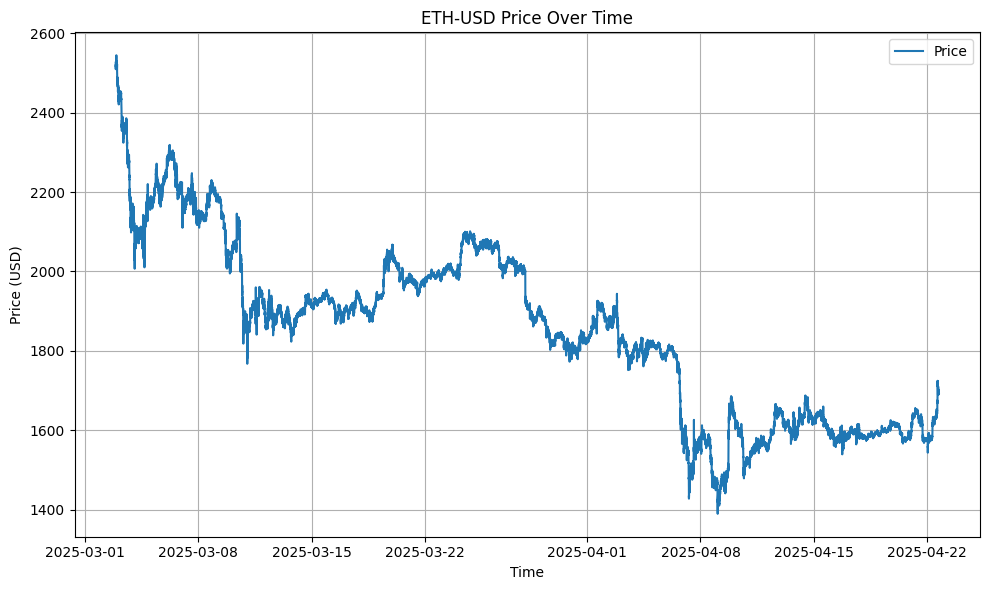

In [915]:
df_trades = df_resampled

# Convert 'price' column to numeric
df_trades['price'] = pd.to_numeric(df_trades['price'])

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(df_trades['time'], df_trades['price'], linestyle='-', label='Price')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('ETH-USD Price Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [916]:
# Ensure time column is sorted
df_trades = df_trades.sort_values('time')

# Scale the 'price' and 'size' column
scaler = MinMaxScaler(feature_range=(0, 1))
#scaler = StandardScaler()
df_trades['price_scaled'] = scaler.fit_transform(df_trades[['price']])

# Create sequences of data for LSTM
sequence_length = 15  # Sequence of 10 observations
forecast_steps = 30     # Predict 5 steps into the future

In [917]:
# Compute percent   difference
df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage

# Drop the first row since pct_change for first row is NaN
df_trades = df_trades.dropna(subset=['pct_change']).reset_index(drop=True)

df_trades = df_trades.drop(columns=[col for col in df_trades.columns if col.startswith("Unnamed")])

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_1014/1791461416.py:2: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df_trades['pct_change'] = df_trades['price'].pct_change() * 100  # Convert to percentage


In [918]:
df_trades['sma_5'] = df_trades['price_scaled'].rolling(window=5).mean()
df_trades['momentum'] = df_trades['price_scaled'] - df_trades['price_scaled'].shift(5)
df_trades.dropna(subset=['sma_5', 'momentum'], inplace=True)
df_trades.head()

,time,price,size,side,price_scaled,pct_change,sma_5,momentum
5,2025-03-02 22:04:00+00:00,2509.32,0.014348,SELL,0.969660,-0.009165,0.973198,-0.013693
6,2025-03-02 22:05:00+00:00,2512.91,0.007834,BUY,0.972770,0.143067,0.971969,-0.006141
7,2025-03-02 22:06:00+00:00,2515.74,0.061357,SELL,0.975221,0.112618,0.972068,0.000494
8,2025-03-02 22:07:00+00:00,2516.03,0.109401,SELL,0.975472,0.011527,0.972596,0.002642
9,2025-03-02 22:08:00+00:00,2515.17,0.419785,BUY,0.974727,-0.034181,0.973570,0.004867


In [919]:
# split data into sequences and X and y
X = []
y = []

prices = df_trades['price_scaled'].values

for i in range(len(prices) - sequence_length - forecast_steps):
    #build feature set

    X.append(prices[i:i + sequence_length])
    y.append(prices [i + sequence_length + forecast_steps - 1])

X = np.array(X)
y = np.array(y)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [920]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [921]:
X_train.shape

(48295, 15, 1)

In [922]:
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(25),
    Dense(1)
])


model.summary()

model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_90 (LSTM)                  │ (None, 15, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_91 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,571 (201.45 KB)

 Trainable params: 51,571 (201.45 KB)

 Non-trainable params: 0 (0.00 B)

In [923]:
# Add Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Stop training if no improvement for 10 epochs
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)


# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stopping])

Epoch 1/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0199 - val_loss: 5.4801e-04
Epoch 2/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 8.8913e-05 - val_loss: 1.5848e-04
Epoch 3/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.7041e-05 - val_loss: 5.9217e-05
Epoch 4/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.4738e-05 - val_loss: 5.6518e-05
Epoch 5/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.4468e-05 - val_loss: 5.6126e-05
Epoch 6/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.3920e-05 - val_loss: 5.5163e-05
Epoch 7/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.1048e-05 - val_loss: 5.5445e-05
Epoch 8/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.1762e-05 - val_loss: 5.6162e-05
Epoch 9/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 7.1129e-05 - val_loss: 6.5482e-05
Epoch 10/100
1510/1510 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 7.1020e-05 - val_loss: 5.3563e-05
Epoch 11/100
1510/1510 

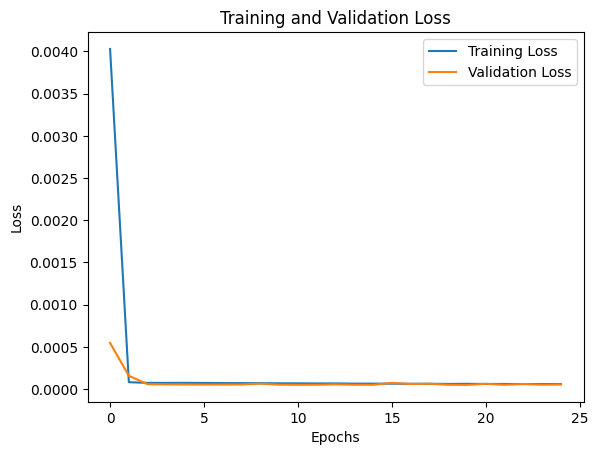

In [924]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [925]:
#save model to h5 format because mac M1 is silly
#model.save("models/model.h5", save_format='h5')
#save model to convert to ONNX model later
save_model(model=model, filepath="models/model.keras")

In [926]:
# Make predictions on the test set
predictions_scaled = model.predict(X_test)

# Inverse transform the predictions and test labels to get original prices
predictions = scaler.inverse_transform(predictions_scaled)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

647/647 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [927]:
model.get_metrics_result()

{'loss': 5.634978515445255e-05}

In [928]:
predictions_scaled[1]

array([0.04174639], dtype=float32)

In [929]:
y_test[10]

0.059663241806448664

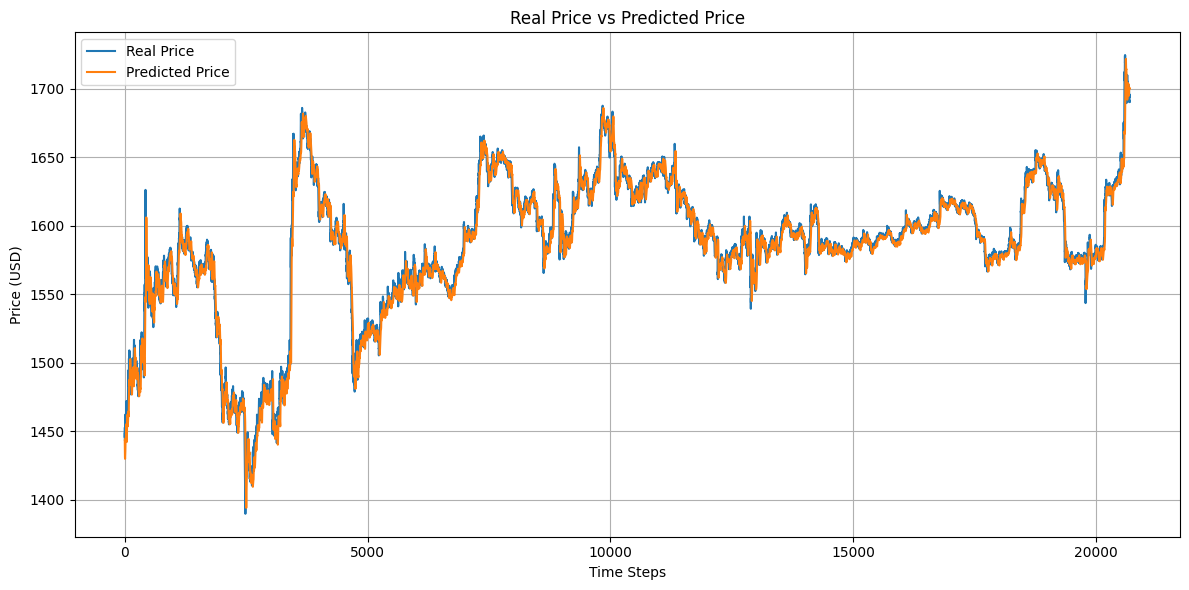

In [930]:
# Plot the real vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Real Price", linestyle='-')
plt.plot(predictions, label="Predicted Price", linestyle='-')
plt.title("Real Price vs Predicted Price")
plt.xlabel("Time Steps")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [931]:
print(f"--------Model Information--------\r\nInterval: {minute * 60} seconds\r\nsequence_length: {sequence_length}\r\nforecast_steps: {forecast_steps}")

--------Model Information--------
Interval: 60 seconds
sequence_length: 15
forecast_steps: 15
